# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Anaconda\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Anaconda\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

#### Evaluating The Customer & Order Tables Separately

In [5]:
# First, we need to know if we have any missing customer names
df_transactions['customer_name'].isna().value_counts()

False    324
Name: customer_name, dtype: int64

In [6]:
#Second, let's get total unique names of Customers)
print(df_transactions['customer_name'].unique())
len(df_transactions['customer_name'].unique())

['Smith' 'Johnson' 'Williams' 'Brown' 'Jones' 'Miller' 'Davis' 'Garcia'
 'Rodriguez' 'Wilson' 'Martinez' 'Anderson' 'Taylor' 'Thomas' 'Hernandez'
 'Moore' 'Martin' 'Jackson' 'Thompson' 'White' 'Lopez' 'Lee' 'Gonzalez'
 'Harris' 'Clark' 'Lewis' 'Robinson' 'Walker' 'Perez' 'Hall' 'Young'
 'Allen' 'Sanchez' 'Wright' 'King' 'Scott' 'Green' 'Baker' 'Adams'
 'Nelson' 'Hill' 'Ramirez' 'Campbell' 'Mitchell' 'Roberts' 'Carter'
 'Phillips' 'Evans' 'Turner' 'Torres' 'Parker' 'Collins' 'Edwards'
 'Stewart' 'Flores' 'Morris' 'Nguyen' 'Murphy' 'Rivera' 'Cook' 'Rogers'
 'Morgan' 'Peterson' 'Cooper' 'Reed' 'Bailey' 'Bell' 'Gomez' 'Kelly'
 'Howard' 'Ward' 'Cox' 'Diaz' 'Richardson' 'Wood' 'Watson' 'Brooks'
 'Bennett' 'Gray' 'James' 'Reyes' 'Cruz' 'Hughes' 'Price' 'Myers' 'Long'
 'Foster' 'Sanders' 'Ross' 'Morales' 'Powell' 'Sullivan' 'Russell' 'Ortiz'
 'Jenkins' 'Gutierrez' 'Perry' 'Butler' 'Barnes' 'Fisher']


100

In [7]:
#Third, let's get a better sense of the order table
df_offers.describe()

,offer_id,min_qty,discount
count,32.000000,32.000000,32.000000
mean,16.500000,65.812500,57.843750
std,9.380832,50.785722,20.770807
min,1.000000,6.000000,17.000000
25%,8.750000,12.000000,44.750000
50%,16.500000,72.000000,55.000000
75%,24.250000,72.000000,82.250000
max,32.000000,144.000000,89.000000


In [8]:
#Fourth, let's see if there are any missing values
df_offers.isna().value_counts()

offer_id  campaign  varietal  min_qty  discount  origin  past_peak
False     False     False     False    False     False   False        32
dtype: int64

So thankfully it would appear that we have two relatively clean and complete tables to work with here! The ultimate goal is to make a table where each row is a customer and then each feature is whether they bought a purchase or not.

#### Creating our desired table

In [9]:
import numpy as np

In [10]:
#First, Let's make a list that has each name:
client_names = df_transactions['customer_name'].unique()
client_names = np.sort(client_names)
#print(client_names)

#Second, let's create a DataFrame with that list
df_customer_orders = pd.DataFrame({'customer_name':client_names})

In [11]:
#Check the DataFrame to see if it worked
df_customer_orders

,customer_name
0,Adams
1,Allen
2,Anderson
3,Bailey
4,Baker
...,...
95,Williams
96,Wilson
97,Wood
98,Wright


In [12]:
#Next, let's add the columns for the order ids
df_customer_orders[['offer_id_1','offer_id_2','offer_id_3','offer_id_4','offer_id_5','offer_id_6','offer_id_7',
                   'offer_id_8','offer_id_9','offer_id_10','offer_id_11','offer_id_12','offer_id_13','offer_id_14',
                   'offer_id_15','offer_id_16','offer_id_17','offer_id_18','offer_id_19','offer_id_20','offer_id_21',
                    'offer_id_22','offer_id_23','offer_id_24','offer_id_25','offer_id_26','offer_id_27','offer_id_28',
                    'offer_id_29','offer_id_30','offer_id_31','offer_id_32']] = 0

In [13]:
#Let's check the df to see that we have everything we need. Rememeber we saw that there are 32 orders
df_customer_orders

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Williams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,Wilson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,Wright,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#Let's make a loop that goes through and checks whether to add a one to a offer_id. First get rows and columns
rows, columns = df_customer_orders.shape
print(f'rows: {rows}')
print(f'columns: {columns}')

rows: 100
columns: 33


In [15]:
#Now let's build our check
for row_count in range(rows):
    for col_count in range(columns):
        name_checker = df_customer_orders.iloc[row_count,0]
        if col_count in list(df_transactions[df_transactions['customer_name'] == name_checker].offer_id):
            df_customer_orders.iloc[row_count,col_count] = 1

In [16]:
#Let's check to see if it at leat makes sense
df_customer_orders.head(10)

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5,Barnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,Bell,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
7,Bennett,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
8,Brooks,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,Brown,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [17]:
#let's Spot check a row
#Let's check Williams
checker = df_transactions[df_transactions['customer_name'] == 'Williams']
checker

,customer_name,offer_id,n
5,Williams,18,1
6,Williams,22,1
7,Williams,31,1


In [18]:
df_checker = df_customer_orders[df_customer_orders['customer_name']=='Williams']
df_checker[['offer_id_5','offer_id_15','offer_id_18','offer_id_20','offer_id_22','offer_id_30','offer_id_31']]

,offer_id_5,offer_id_15,offer_id_18,offer_id_20,offer_id_22,offer_id_30,offer_id_31
95,0,0,1,0,1,0,1


#### Finished making the table!

Phew! Looks like we did it! I'll want to check in with mentor regarding what is the best way to accomplish this task.

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [19]:
# your turn
#Let's create the columns
x_cols = df_customer_orders.drop(['customer_name'],axis=1)
x_cols

,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
96,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
97,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
98,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [20]:
#Import the relevant packages
from sklearn.cluster import KMeans

In [21]:
#First, let's make our model and fit it
kmean_model = KMeans(random_state = 0).fit(x_cols)

In [22]:
#Let's make an inertia plot for this situation
#Initialize an inertias list and a ranges of ks
inertias = []
ks = range(2,11)

In [23]:
#Test the model for various K's
for k in ks:
    #Create model
    kmean_model_tester = KMeans(n_clusters= k, random_state=0).fit(x_cols)
    #Append Inertia
    inertias.append(kmean_model_tester.inertia_)

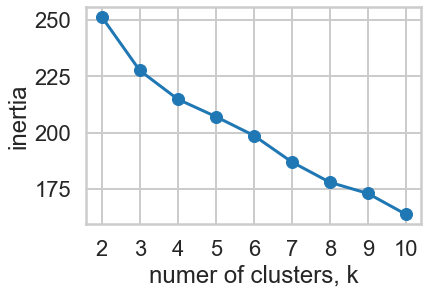

In [24]:
#Let's make the elbow plot now
plt.plot(ks, inertias, '-o')
plt.xlabel('numer of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [25]:
#Unfortunatley, it looks like you may need 10 clusters at least for this data set because we don't get a nice elbow
kmean_model = KMeans(n_clusters=10, random_state = 0).fit(x_cols)
labels = kmean_model.fit_predict(x_cols)

In [26]:
unique, counts = np.unique(labels, return_counts=True)

In [27]:
df_labels = pd.DataFrame({'Cluster':unique,'Count':counts})

In [28]:
df_labels

,Cluster,Count
0,0,14
1,1,15
2,2,13
3,3,10
4,4,9
5,5,4
6,6,4
7,7,7
8,8,2
9,9,22


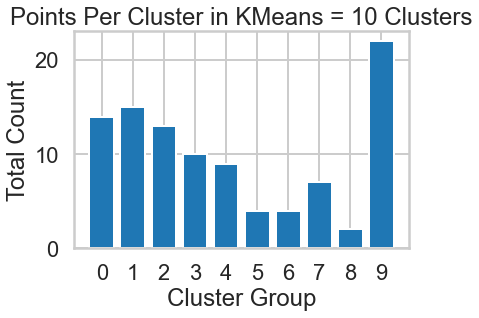

In [29]:
#df_labels
plt.bar(x=df_labels.Cluster,height=df_labels.Count)
plt.xticks(range(0,10))
plt.ylabel('Total Count')
plt.xlabel('Cluster Group')
plt.title('Points Per Cluster in KMeans = 10 Clusters')
plt.show()

Based on the bar chart, we can see that some clusters have a lot of members (Cluster 9 for example) while other clusters are pretty spares (5 & 6 for example). This raises a questino of how well we can really use the elbow graph by just eyeballing it unfortunately.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [30]:
# Your turn.
# let's start by just trying to make a silhouette plot of a n_clusters = 2
# First we need to import the relevant packages
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.12101628521627421
For n_clusters = 4 The average silhouette_score is : 0.13421536289944658
For n_clusters = 5 The average silhouette_score is : 0.11749792889789946
For n_clusters = 6 The average silhouette_score is : 0.11001951281555851
For n_clusters = 7 The average silhouette_score is : 0.1389060957347788
For n_clusters = 8 The average silhouette_score is : 0.10969644130551678
For n_clusters = 9 The average silhouette_score is : 0.12267242922234355
For n_clusters = 10 The average silhouette_score is : 0.12728046874135684


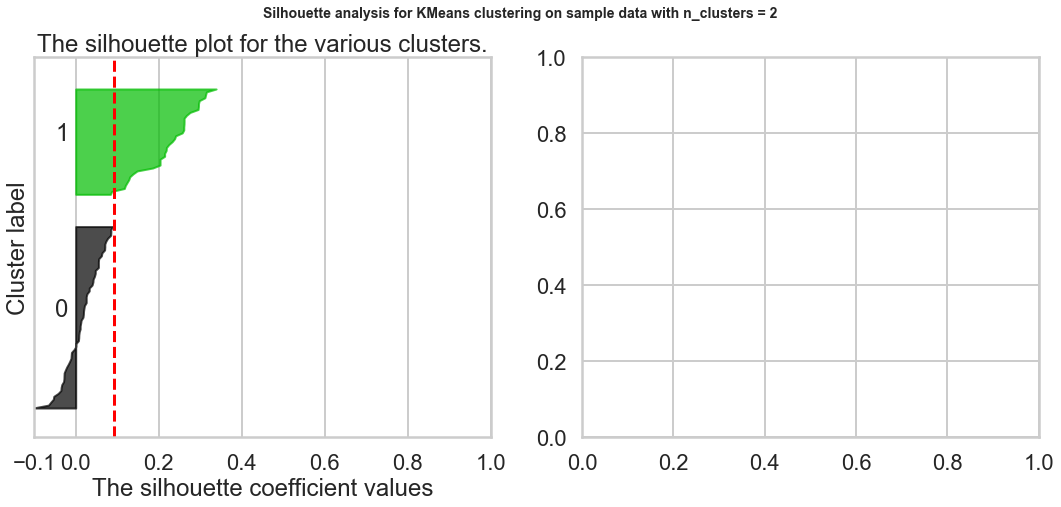

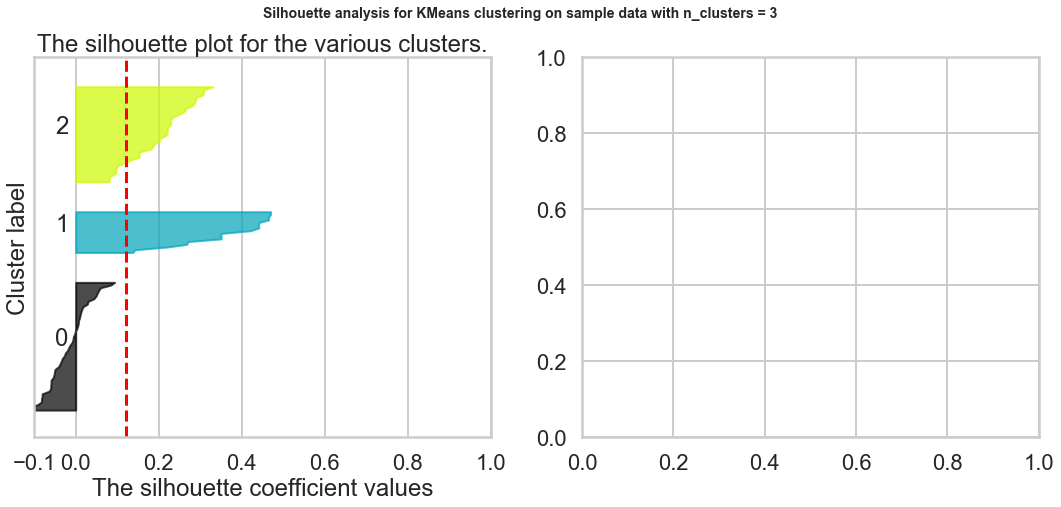

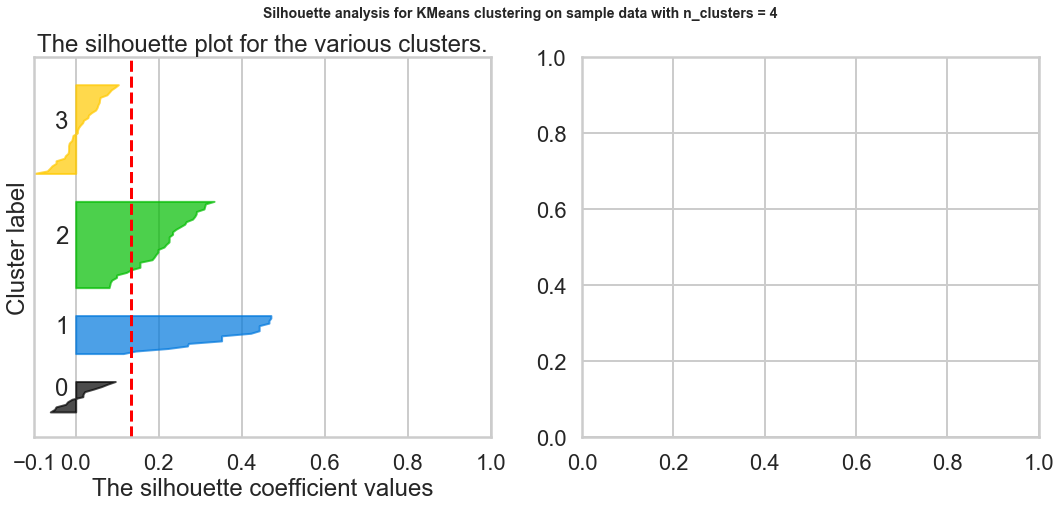

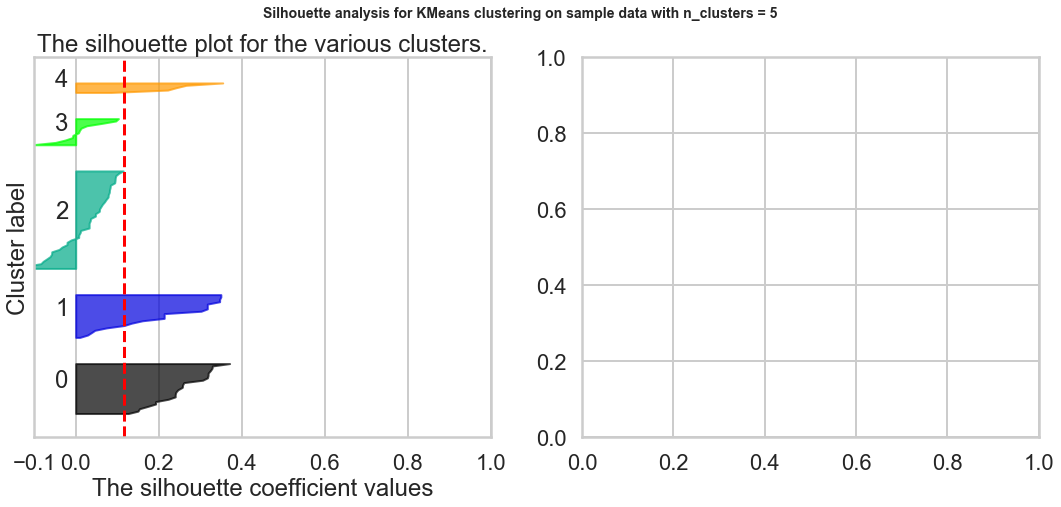

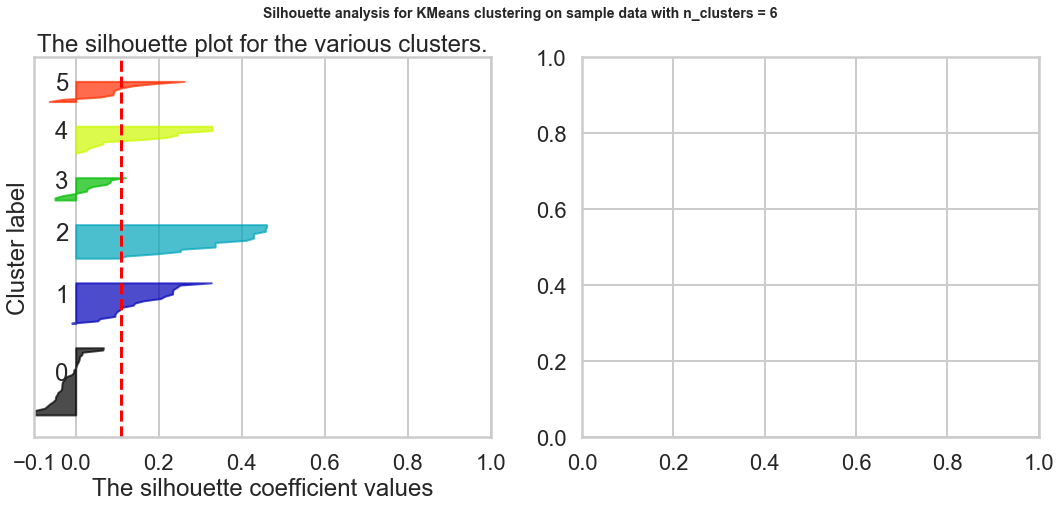

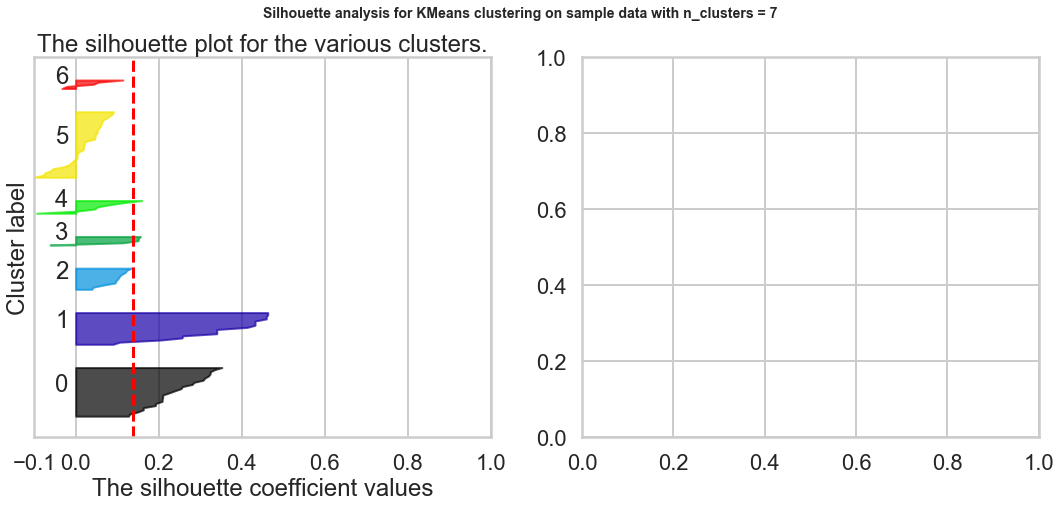

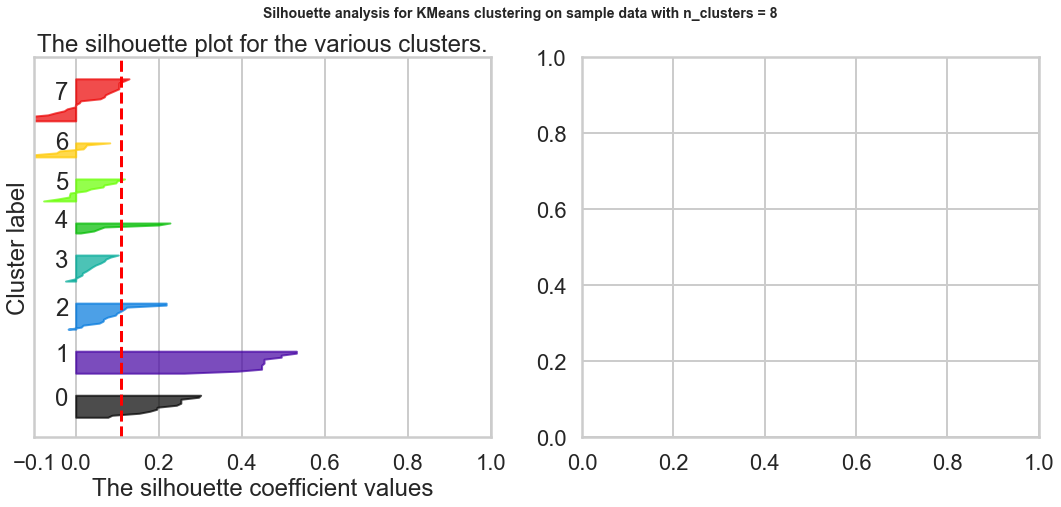

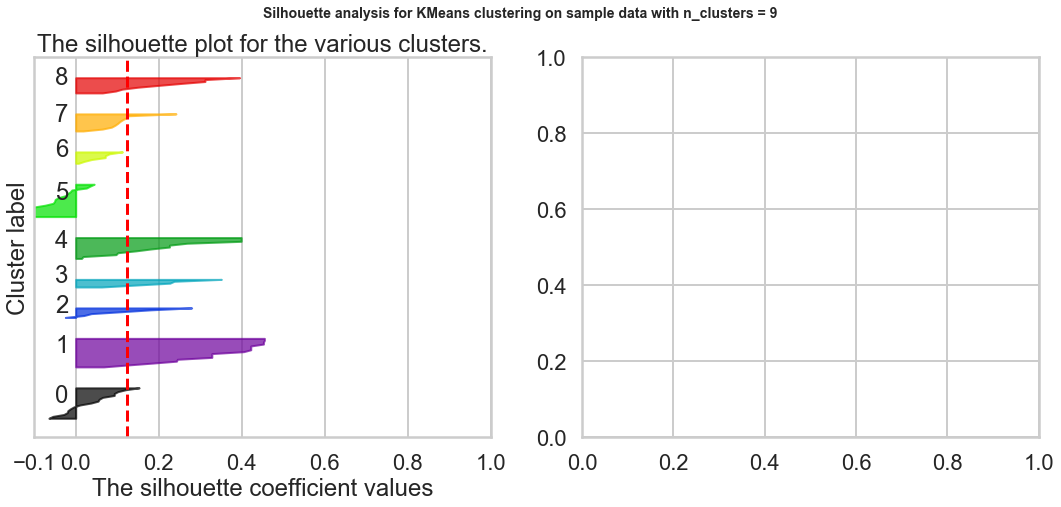

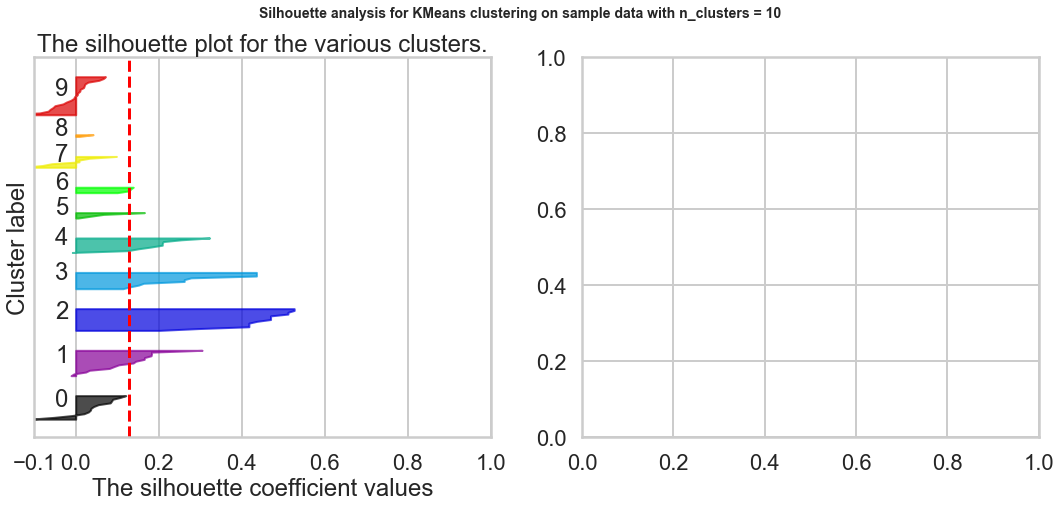

In [31]:
range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    ## 2nd Plot showing the actual clusters formed
    ##colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ##ax2.scatter(
        ##x_cols[:, 0], x_cols[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    ##)

    # Labeling the clusters
    ##centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ##ax2.scatter(
        ##centers[:, 0],
        ##centers[:, 1],
        ##marker="o",
        ##c="white",
        ##alpha=1,
        ##s=200,
        ##edgecolor="k",
    ##)

    ##for i, c in enumerate(centers):
        ##ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ##ax2.set_title("The visualization of the clustered data.")
    ##ax2.set_xlabel("Feature space for the 1st feature")
    ##ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

We can't do the 2nd plot because our data is in 32-dimensions but we can see that some n_cluster amounts are superior to others

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [32]:
#your turn
# First we need to import the relevant package
from sklearn.decomposition import PCA

In [33]:
#Next, we create our PCA model with 2 components
pca = PCA(n_components = 2, random_state = 0)

In [34]:
#Now we can fit the PCA model to our data
pca.fit(x_cols)

PCA(n_components=2, random_state=0)

In [35]:
#Next we'll build up our DataFrame for analysis
df_pca = pd.DataFrame({'customer_name':df_customer_orders['customer_name']})
df_pca['cluster_id'] = labels
df_pca

,customer_name,cluster_id
0,Adams,1
1,Allen,9
2,Anderson,2
3,Bailey,4
4,Baker,4
...,...,...
95,Williams,0
96,Wilson,3
97,Wood,7
98,Wright,9


In [36]:
transformed = pca.transform(x_cols)
df_pca['x'] = transformed[:,0]
df_pca['y'] = transformed[:,1]
df_pca

,customer_name,cluster_id,x,y
0,Adams,1,1.007580,0.108215
1,Allen,9,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,4,0.699477,-0.022542
4,Baker,4,0.088183,-0.471695
...,...,...,...,...
95,Williams,0,-0.151666,-0.587844
96,Wilson,3,0.688224,-0.013688
97,Wood,7,-0.551215,-0.395670
98,Wright,9,-0.489805,-0.383307


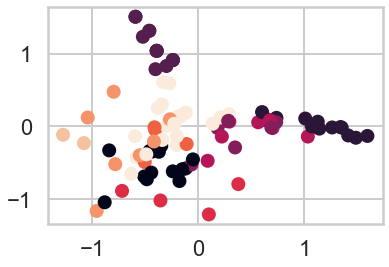

In [37]:
plt.scatter(x='x',y='y',data=df_pca,c='cluster_id')

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

So based on these results, I would say that 10 clusters just doesn't make sense even though there wasn't a nice elbow. After talking with my mentor, he recommended 3 clusters because at least there was a 'slight' elbow to consider and based on what I'm seeing with scatter plot, I have to agree because it lokos like you can get 3 reasonable clusters.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

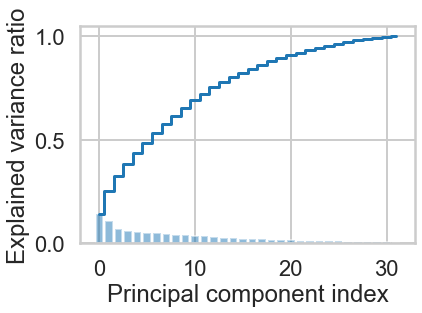

In [38]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca_optimal = PCA()
pca_optimal_results = pca_optimal.fit_transform(x_cols)
exp_var_pca = pca_optimal.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.show()

It seems like "3" is probably the best answer as it starts to level out pretty quickly after 3 components. That said, it would appear this data set isn't the easiest set to reduce the dimensions into something more easily comprehensible.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

It would appear that KMeans and PCA are very powerful tools to use but they won't always necessarily give you an easy answer. If anything, this exercise really highlightd that sometimes, you need to examine different parameters to see which ones make the most sense and then perhaps seeks content expert input / context clues to understand what the analyses are showing. That said, I really learned a lot from this case study and enjoyed it quite thoroughly. It definitely helped me understand a lot of components and some things I may need to work on as well! Cheers! Emre

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [39]:
# Your turn